In [1]:
import os
import time
from datetime import datetime
import numpy as np
#import matplotlib.pyplot as plt
from collections import deque
import gym
import pandas as pd
from pathlib import Path
import sys
import random
import tensorflow as tf
from sqlalchemy import create_engine

from environments import PortfolioEnvironment
from utils import ReplayBufferMultiObs
from policies import TD3

In [2]:
def reshape_dict_state(state):
    obs = {}
    for key,value in state.items():
        obs[key] = np.array([value])
    return obs

In [3]:
engine = create_engine(f'mysql+pymysql://{os.environ["MYSQL_USER"]}:{os.environ["MYSQL_PASSWORD"]}@{os.environ["MYSQL_SERVER"]}:{os.environ["MYSQL_PORT"]}/tfm')

In [4]:
seed = 0
start_timesteps = 1e4 # Number of timesteps in which the model choose a random action, after that number starts using the policy
save_freq = 5e3
max_timesteps = 5e5 
expl_noise = 0.0 # Exploration noise 
batch_size = 100 
discount = 0.97 # reward Discount factor gamma 
tau = 0.005 # target weights update ratio
policy_noise = 0.2 # std deviation of gaussian noise to be added to the action, for exploration purposes
noise_clip = 0.9 # max value of gaussian noise added to action
policy_freq = 2 # actor model weights update frecuency


In [5]:
model_path = './models/06_05_2022_17_41_13'
load_model = True 
max_steps = 200
fee = 0.25/100
window = 50

In [6]:
#tickers = ['AAPL','AMZN','COIN','FB','GOOG','MSFT','NVDA','SQ','TSLA','V','XOM']
assets_data_list = []
assets_data_list_test = []
tickers = {v: k for k, v in engine.execute("SELECT id,ticker FROM tickers order by id asc").fetchall()}
for t in tickers.keys():
    #assets_data_list.append(pd.read_csv(f'./data/{t}.csv'))
    assets_data_list.append(pd.read_sql(f"SELECT close,high,low from historical_hour inner join tickers on ticker_id = tickers.id where ticker = '{t}' order by time asc",engine))
    assets_data_list_test.append(assets_data_list[-1].tail(max_steps+window))
    assets_data_list[-1] = assets_data_list[-1].iloc[:assets_data_list[-1].shape[0]-max_steps,]
    

Por algun motivo cuando agrego otro feature que tiene el indice, hay mejores resultados
Cosas por probar: seguir entrenando, con diferentes expl_noise, cambiar la funcion softmax de activacion por una custom q no tome los exponentes, reentrenar usando el modelo en ./models/03_05_2022_13_35_56 , se entreno con datos normalizados, 

cambiar la funcion softmax de activacion por una custom q no tome los exponentes, probar que pasa si no estan normalizados, Se cambiaron ambas cosas hubo mejores resultados, ahora los weights no se mantienen constante aun poniendo la exploracion en cero, el resultado de ese modelo esta en ./models/05_05_2022_09_53_14

Probar nuevamente datos normalizados, en la ultima columna dejar el numero de episodio, pero que vaya siempre desde 1 al ultimo del batch, esto esta en ./models/06_05_2022_17_41_13


funcion reward que tenga en cuenta cuanta guita esta haciendo pero tambien comparar contra un indicador del mercado esto es para lograr que recompense mejor si esta opearndo por encima del mercado

In [7]:
env = PortfolioEnvironment(tickers.keys(),assets_data_list,fee=fee,look_back_window=window,max_steps=max_steps)

In [8]:
state_dim = env.observation_space["data"].shape
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [9]:
policy = TD3(state_dim,action_dim,max_action)

replay_buffer = ReplayBufferMultiObs()

In [10]:
if load_model:
    policy.load(model_path)

In [11]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
saved_models_path = f'./models/{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}'

In [13]:
start_time=time.time()
info_list = []
while total_timesteps < max_timesteps:
    if done:
        if total_timesteps != 0:
            print(f'Total timesteps: {total_timesteps} Episode Num: {episode_num} Reward: {episode_reward} Portfolio Value:{env.portfolio_value_units}')
            policy.train(replay_buffer,episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
        
        if timesteps_since_eval >= save_freq:
            timesteps_since_eval %= save_freq
            policy.save(saved_models_path)

        
        obs = env.reset()
        done = False
        
        episode_reward = 0
        episode_timesteps = 0
        episode_num +=1
        
    if total_timesteps < start_timesteps:
        action = tf.nn.softmax(env.action_space.sample()+ np.random.normal(0,1,size=env.action_space.shape[0])).numpy()
    else:
        action = policy.select_action(reshape_dict_state(obs))
        #print(action)
        if expl_noise != 0: 
            action = tf.nn.softmax((action + np.random.normal(0,expl_noise,size=env.action_space.shape[0]))).numpy()
    
    
    next_obs,reward,done, info = env.step(action)
    info_list.append(info)
    done_bool = 0 if episode_timesteps +1 == env.max_steps else float(done)
    
    
    episode_reward += reward
    replay_buffer.add((obs,next_obs,action,reward,done_bool))
    
    obs = next_obs
    episode_timesteps +=1
    total_timesteps +=1
    timesteps_since_eval +=1


policy.save(saved_models_path)
print(f'Tiempo de entrenamiento: {time.time()-start_time} segundos')

Total timesteps: 200 Episode Num: 1 Reward: -30281.900785148464 Portfolio Value:69718.09921485154
Total timesteps: 400 Episode Num: 2 Reward: -37985.76004593694 Portfolio Value:62014.23995406306
Total timesteps: 600 Episode Num: 3 Reward: -31049.879304328337 Portfolio Value:68950.12069567166
Total timesteps: 800 Episode Num: 4 Reward: -30680.14809680295 Portfolio Value:69319.85190319705
Total timesteps: 1000 Episode Num: 5 Reward: -37030.43876391453 Portfolio Value:62969.56123608547
Total timesteps: 1200 Episode Num: 6 Reward: -39262.7915801974 Portfolio Value:60737.2084198026
Total timesteps: 1400 Episode Num: 7 Reward: -33095.673577229405 Portfolio Value:66904.3264227706
Total timesteps: 1600 Episode Num: 8 Reward: -34396.74188407799 Portfolio Value:65603.25811592201
Total timesteps: 1800 Episode Num: 9 Reward: -30102.456131735627 Portfolio Value:69897.54386826437
Total timesteps: 2000 Episode Num: 10 Reward: -40408.48426391983 Portfolio Value:59591.51573608017
Total timesteps: 2200 

In [12]:
import matplotlib.pyplot as plt
from environments import PortfolioEnvironmentTest

In [16]:
env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)
state = env2.reset()
done = False
total_reward = 0

while not done:
    action = policy.select_action(reshape_dict_state(state))
    state, reward, done, _ = env2.step(action)
    total_reward += reward
    print(action)

total_reward

[0.02008257 0.08896216 0.08912521 0.08908156 0.08910318 0.08890796
 0.0888957  0.08934015 0.0896727  0.08928972 0.08894558 0.08859356]
[0.00041433 0.0907461  0.09085922 0.09089975 0.09089313 0.09064789
 0.09066834 0.09110401 0.09148892 0.09109654 0.09075958 0.09042224]
[8.5491647e-06 9.0759546e-02 9.0873785e-02 9.1026768e-02 9.0947472e-02
 9.0672173e-02 9.0699762e-02 9.1141455e-02 9.1541976e-02 9.1114827e-02
 9.0795800e-02 9.0417884e-02]
[1.7638681e-07 9.0742491e-02 9.0808742e-02 9.1102533e-02 9.0942480e-02
 9.0645805e-02 9.0687029e-02 9.1150336e-02 9.1611281e-02 9.1086924e-02
 9.0780459e-02 9.0441763e-02]
[3.6392471e-09 9.0739094e-02 9.0814240e-02 9.1155544e-02 9.0963013e-02
 9.0669796e-02 9.0721875e-02 9.1139048e-02 9.1595009e-02 9.1001108e-02
 9.0799600e-02 9.0401627e-02]
[7.5011289e-11 9.0713382e-02 9.0823404e-02 9.1234565e-02 9.1004767e-02
 9.0682007e-02 9.0665907e-02 9.1067798e-02 9.1708004e-02 9.0978466e-02
 9.0740331e-02 9.0381339e-02]
[1.5457328e-12 9.0728559e-02 9.0833947e-02

-13585.950645996389

# ------ PRUEBAS---------

In [27]:
max_value = 0
index = 0
for i,v in enumerate(info_list):
    if v['value'] > max_value:
        max_value = v['value']
        index = i
print(max_value)
print(info_list[index])


1.1928068269087038
{'weights': array([0.        , 0.12493297, 0.        , 0.12493297, 0.12493297,
       0.        , 0.12493297, 0.12493297, 0.12493297, 0.00053627,
       0.12493297, 0.12493297], dtype=float32), 'value': 1.1928068269087038, 'position': 940}


In [45]:
info_list[index-173] #+26 es el ultimo

{'weights': array([0.1279268 , 0.1328057 , 0.        , 0.07251303, 0.04147185,
        0.        , 0.05293043, 0.08518989, 0.0713501 , 0.00406993,
        0.07308968, 0.33865255], dtype=float32),
 'value': 0.9978198170743418,
 'position': 767}

In [46]:
#pos 249
weights = []
for d in info_list[index-173:index+27]:
    weights.append(d['weights'])
weights = np.array(weights)
weights.shape

(200, 12)

In [51]:
weights[3]

array([2.29485458e-10, 1.21506825e-01, 0.00000000e+00, 1.21506825e-01,
       1.21506825e-01, 0.00000000e+00, 1.21506825e-01, 1.21506825e-01,
       1.21506825e-01, 2.79453751e-02, 1.21506825e-01, 1.21506825e-01],
      dtype=float32)

In [47]:
data = env.buffer.data
data = data[:,50:250,1].T
data = np.concatenate((np.ones(shape=(data.shape[0],1)),data),axis=1)
data

array([[1.00000e+00, 1.27780e+02, 3.20927e+03, ..., 6.45960e+02,
        2.26920e+02, 5.98600e+01],
       [1.00000e+00, 1.27860e+02, 3.21878e+03, ..., 6.45240e+02,
        2.26860e+02, 5.99200e+01],
       [1.00000e+00, 1.27720e+02, 3.22276e+03, ..., 6.38120e+02,
        2.25840e+02, 6.00200e+01],
       ...,
       [1.00000e+00, 1.30440e+02, 3.50097e+03, ..., 6.24820e+02,
        2.30520e+02, 5.89100e+01],
       [1.00000e+00, 1.30270e+02, 3.49281e+03, ..., 6.25000e+02,
        2.30720e+02, 5.86100e+01],
       [1.00000e+00, 1.30400e+02, 3.49101e+03, ..., 6.22430e+02,
        2.30380e+02, 5.86400e+01]])

In [49]:
data.shape

(200, 12)

In [66]:
portfolio_value = []
valor = 100000
for i in range(1,data.shape[0]):
    valor = (weights[i-1]*valor/data[i-1]*data[i]).sum()
    portfolio_value.append(valor)

<AxesSubplot:>

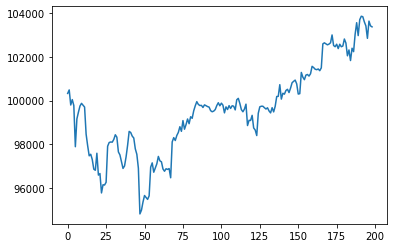

In [73]:
pd.Series(portfolio_value).plot()